# Idée générale de la méthode:

    on effectue du clustering sur les trajectoires, on considère les clusters obtenus comme des classes
    
    on effectue du clustering sur l'ensemble des premiers points des trajectoires
    
        cela nous donne les principales types de zones d'entrée d'objets sur l'intersection
        
        on considère ces clusters comme des classes
        
        on entraine un classifieur pour les classes de point d'entrée
        
    on créer un dataset de sous-trajectoires extraites des trajectoires du dataset
    
            on entraine un classificateur 
            
                qui prend en entrée: 
                
                    la classe du point de départ de la sous_trajectoire
                    
                    des statistiques calculées sur la sous-trajectoire
                    
                et qui prédit la classe de la sous-trajectoire

# probleme classification de points

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s
import test

import time

In [2]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

faut il effectuer le clustering sur tout le dataset et séparer ensuite
en ensemble d'entrainement/test (afin de pouvoir tester les performances à la toute fin
ou non?)

# Load Dataset (positions and velocities)

In [3]:
nb_trajectories_per_object = 1
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories_o = np.array([t for o in trajectories_po for t in o])
velocities_o = np.array([ft.compute_velocities(t) for t in trajectories_o])
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories_o]

In [4]:
ids = np.loadtxt(SAVE_PATH + "ids.txt")
ids = np.array([int(i) for i in ids])
nb_trajectories = len(ids)
X_features = np.loadtxt(SAVE_PATH + "features.txt")
X_targets_ = np.loadtxt(SAVE_PATH + "targets.txt")
trajectories_ = trajectories_o[ids]
velocities_ = velocities_o[ids]
X_targets_ = np.array([int(x) for x in X_targets_])



In [5]:
m = np.max(X_targets_)
prop = [0 for k in range(m+1)]
ids_po = []
for i in range(m+1):
    id_ = []    
    for j,c in enumerate(X_targets_):
        if c == i:
            prop[c] +=1
            id_.append(j)
    ids_po.append(id_)


min_ = np.min(prop)
id_filtered = []
for i in range(m):
    idr = np.random.choice(ids_po[i],min_,replace = False)
    for e in idr:
        id_filtered.append(e)

In [6]:
id_filtered = np.array(id_filtered)

In [7]:
trajectories = trajectories_[id_filtered]
X_targets = X_targets_[id_filtered]
X_velocities = np.array([ft.compute_velocities(t) for t in trajectories])

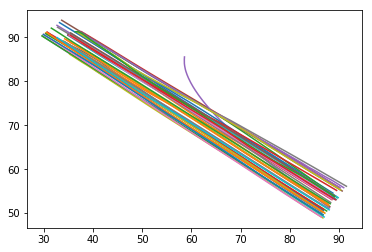

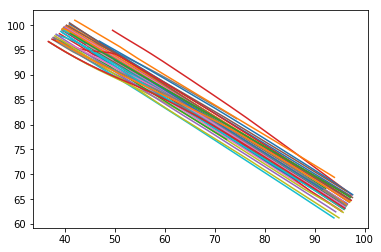

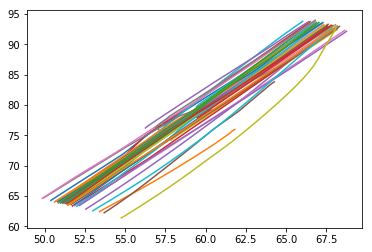

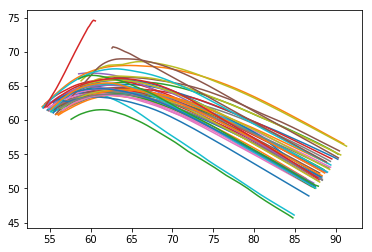

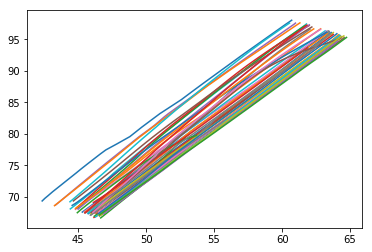

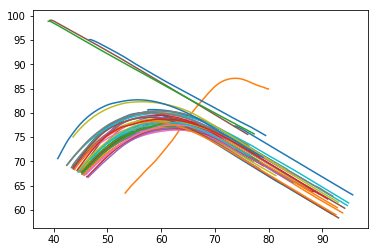

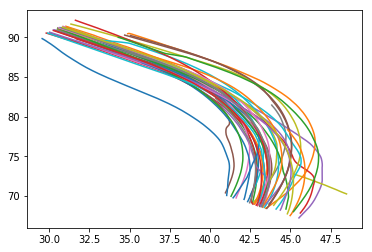

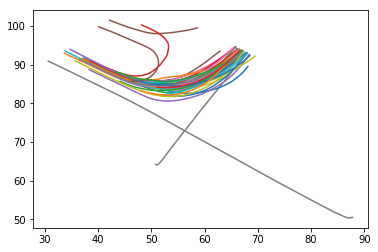

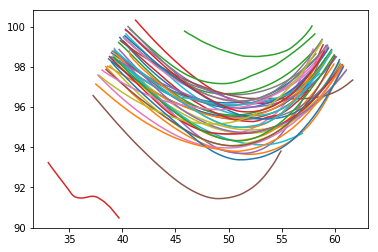

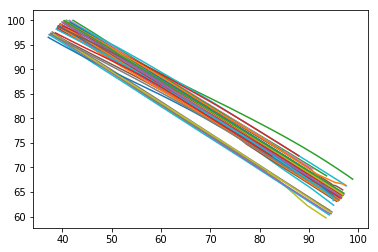

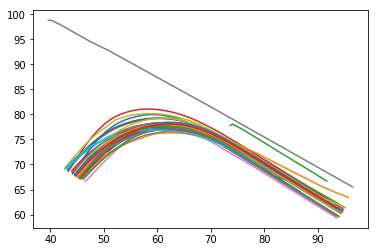

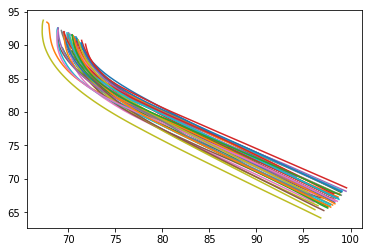

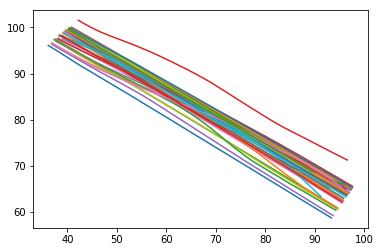

In [8]:
for i in range(m+1):
    traj = []
    #count_ = 0
    for j,c in enumerate(X_targets):
        if c == i:
            traj.append(trajectories[j])
    #prop.append(count)
    
    ut.refactor_and_plot(traj)

### Separate features between train and test set

In [9]:
test_prop = 0.2
ids_train, ids_test = train_test_split(np.arange(len(trajectories)), test_size = test_prop)

X_train_trajectories = trajectories[ids_train]
X_train_velocities = X_velocities[ids_train]
X_train_targets = X_targets[ids_train]

X_test_trajectories = trajectories[ids_test]
X_test_velocities = X_velocities[ids_test]
X_test_targets = X_targets[ids_test]

### CLustering on starting points to learn the different categories of starting points

In [10]:
ex = id_filtered[ids_test]
ids_for_point = []
for i in range(len(trajectories_)):
    if i not in ex:
        ids_for_point.append(i)

In [11]:
points_data,points,nb_points = test.get_first_points_data(X_train_trajectories, X_train_velocities )
#points_data,points,nb_points = test.get_first_points_data(trajectories_[ids_for_point], velocities_[ids_for_point] )

In [12]:
pd.DataFrame(points_data).T

,0,1,2,3,4,5,6,7,8,9,...,447,448,449,450,451,452,453,454,455,456
0,60.390400,98.088600,67.785300,64.110100,61.86400,93.233600,98.028300,91.733300,90.278200,95.327800,...,91.102800,90.642600,91.276500,70.78420,63.783100,93.918800,62.248300,91.393100,58.973900,90.46150
1,94.210400,60.692000,98.191600,96.554100,55.61120,33.011100,60.705000,37.206300,34.693000,64.260900,...,30.537800,30.022200,36.457500,78.98810,96.280100,33.692800,95.496500,37.003900,92.506000,31.90120
2,0.351561,-0.106925,0.313881,0.310637,0.04856,-0.141405,-0.285775,-0.454147,-0.164671,-0.342433,...,-0.104798,-0.132659,-0.327832,0.05339,0.524925,-0.281678,0.404708,-0.199877,0.059242,-0.04665
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [13]:
nb_points

457

t.standardize_features(points_data) fonctionne par référence ça casse tout

#### Apply standardization and PCA for starting points clustering

In [14]:
points_data_std,scaler_points = ft.standardize_features(points_data)
points_data_std = pd.DataFrame(points_data_std)


pca_points = PCA(n_components=0.99)
points_data_std_pca = pca_points.fit_transform(points_data_std)

pca_points = pca_points.set_params(n_components=pca_points.n_components_)

pca_points.n_components_

3

In [15]:
#points_data_std_pca,scaler_points,pca_points = test.standardize_and_reduce_dimensions(points_data)
#points_data_std_pca,scaler_points,pca_points = test.standardize_and_reduce_dimensions(points)

optimal numbers of clusters: [6, 9, 11]


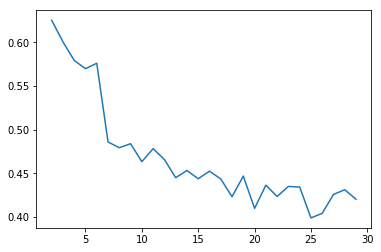

In [16]:
from sklearn.cluster import AgglomerativeClustering,SpectralClustering
algo = KMeans()
max_clusters = 30
nb_clusters = test.get_optimal_cluster_number(max_clusters,points_data_std_pca,algo,True)

In [17]:
nb_clusters = 14

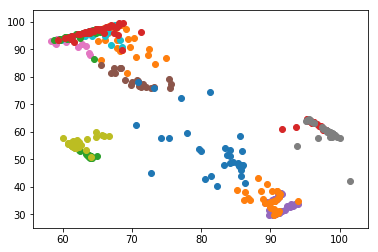

In [18]:
point_targets,clusterer = test.plot_points_clusters(nb_clusters,algo,points_data_std_pca,points)

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
point_test_prop = 0.20
ids_train, ids_test, [points_data_train,point_targets_train], [points_data_test,point_targets_test ] = test.split_train_test(nb_points,[points_data,point_targets], point_test_prop)
#ids_train, ids_test, [points_data_train,point_targets_train], [points_data_test,point_targets_test ] = test.split_train_test(nb_points,[points,point_targets], point_test_prop)

In [21]:
point_classifier_train = RandomForestClassifier()
point_classifier_train = point_classifier_train.fit(points_data_train,point_targets_train)
train_point_pred = point_classifier_train.predict(points_data_train)
test_point_pred = point_classifier_train.predict(points_data_test)

In [22]:
print("train error: " + str(f1_score(point_targets_train,train_point_pred,average = "micro")))
print("test error: " + str(f1_score(point_targets_test,test_point_pred,average = "micro")))

train error: 0.9972602739726028
test error: 0.9782608695652174


In [23]:
point_classifier = RandomForestClassifier()
point_classifier = point_classifier.fit(points_data,point_targets)

# Train partial trajectory classifier

To learn how to classify a subtrajectory, the features will be the starting point class (as a binary representation) and stats on the subtrajectory

## Random subtrajectories extraction

For each trajectory in the training set, for a defined number of sub trajectory per trajectory, we pick a subtrajectory whose size is randomly pick between 3 and the minimum trajectory length of the trajectory

In [24]:
X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets = test.extract_subtrajectories(X_train_trajectories,X_train_velocities,X_train_targets,point_targets,0.7,20,4)

### Get train and test set for trajectory classification

In [25]:
to_split = [X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets]

ids_train, ids_test, trains, tests = test.split_train_test(len(X_sub_trajectories),to_split, 0.20)

[X_train_sub_trajectories,X_train_sub_velocities,X_train_sub_targets,X_train_sub_point_targets] = trains
[X_test_sub_trajectories,X_test_sub_velocities,X_test_sub_targets,X_test_sub_point_targets] = tests

### Compute features and normalize

In [26]:
X_train_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_train_sub_trajectories,X_train_sub_velocities)]
X_train_sub_features = pd.DataFrame(X_train_sub_features)

##### use the same standardizer fit with train for test

In [27]:
X_test_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_test_sub_trajectories,X_test_sub_velocities)]
X_test_sub_features = pd.DataFrame(X_test_sub_features)

### one hot encode the subtrajectory starting point class

In [28]:
ohe_train_trajectory = OneHotEncoder(sparse = False, dtype=np.int)

one_hot_train_startpoint_class = pd.DataFrame(ohe_train_trajectory.fit_transform(X_train_sub_point_targets.reshape(-1,1)))
one_hot_test_startpoint_class = pd.DataFrame(ohe_train_trajectory.transform(X_test_sub_point_targets.reshape(-1,1)))

In [29]:
X_train = pd.concat([one_hot_train_startpoint_class,X_train_sub_features], axis=1, join='outer')
y_train = X_train_sub_targets

In [30]:
X_test = pd.concat([one_hot_test_startpoint_class,X_test_sub_features], axis=1, join='outer')
y_test = X_test_sub_targets

### Train classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
subtrajectory_classifier = RandomForestClassifier()

In [32]:
subtrajectory_classifier = subtrajectory_classifier.fit(X_train,y_train)
train_pred = subtrajectory_classifier.predict(X_train)
test_pred = subtrajectory_classifier.predict(X_test)

#### classification performances

In [33]:
print("train error: " + str(f1_score(X_train_sub_targets,train_pred,average = "micro")))
print("test error: " + str(f1_score(X_test_sub_targets,test_pred,average = "micro")))

train error: 0.999589715536105
test error: 0.9912472647702407


In [34]:
print(confusion_matrix(X_test_sub_targets,test_pred))

[[134   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 155   0   0   0   0   0   0   0   3   0   0   1]
 [  0   0 117   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 149   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 113   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 143   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0 134   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0 161   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0 148   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1 158   0   1]
 [  0   0   0   0   0   0   0   0   0   1   0 141   0]
 [  0   2   0   0   0   0   0   0   0   0   1   0 135]]


#### retrain on the whole dataset

In [35]:
ohe_trajectory = OneHotEncoder(sparse = False, dtype=np.int)
one_hot_startpoint_class = pd.DataFrame(ohe_trajectory.fit_transform(X_sub_point_targets.reshape(-1,1)))

X_train_sub_features = pd.DataFrame(X_train_sub_features)
X_test_sub_features = pd.DataFrame(X_test_sub_features)

X_sub_features = pd.concat([X_train_sub_features,X_test_sub_features]).reset_index(drop=True)
X = pd.concat([one_hot_startpoint_class,X_sub_features], axis=1, join='outer')
y = X_sub_targets

X = pd.DataFrame(X)
X.columns = np.arange(X.shape[1])

In [36]:
subtrajectory_classifier = RandomForestClassifier()
subtrajectory_classifier = subtrajectory_classifier.fit(X,y)

# Apply on unseen trajectories

In [37]:
points_data_test,points_test,nb_points_test = test.get_first_points_data(X_test_trajectories, X_test_velocities )

In [38]:
point_targets_test = point_classifier.predict(points_data_test)

In [39]:
pd.DataFrame(point_targets_test).T

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,4,1,1,11,5,1,8,12,8,2,...,1,3,10,2,10,12,2,3,7,0


In [40]:
X_sub_trajectories_test,X_sub_velocities_test,X_sub_targets_test,X_sub_point_targets_test = test.extract_subtrajectories(X_test_trajectories,X_test_velocities,X_test_targets,point_targets_test,0.7,10,4)

In [41]:
one_hot_startpoint_class_test = pd.DataFrame(ohe_trajectory.transform(X_sub_point_targets_test.reshape(-1,1)))

In [42]:
X_sub_features_test = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_sub_trajectories_test,X_sub_velocities_test)]
X_sub_features_std_test = pd.DataFrame(X_sub_features_test)

In [43]:
X_test = pd.concat([one_hot_startpoint_class_test,X_sub_features_std_test], axis=1, join='outer')
y_test = X_sub_targets_test

In [44]:
final_pred = subtrajectory_classifier.predict(X_test)

In [45]:
print("test error: " + str(f1_score(y_test,final_pred,average = "micro")))

test error: 0.5478260869565217


In [46]:
print("test error: " + str(f1_score(y_test,final_pred,average = None)))

test error: [0.37209302 0.15602837 0.86925795 0.81967213 0.68831169 0.91489362
 0.43428571 0.52554745 0.79824561 0.         0.14117647 0.5511811
 0.35897436]


In [47]:
print(confusion_matrix(y_test,final_pred))

[[ 32   0   0   0   0   0  28  20   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0   0  10  35  10  14]
 [  6   9 123   2   0   0   0   0   0   0   0   0   0]
 [  0   0  20  50   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  53   0   0   0  27   0   0   0   0]
 [  0   2   0   0   0  86   0   0   0   0   1   3   8]
 [ 41   0   0   0   0   0  38  11   0   0   0   0   0]
 [ 13   0   0   0   2   0  19  36   0   0   0   0   0]
 [  0   0   0   0  19   0   0   0  91   0   0   0   0]
 [  0   7   0   0   0   0   0   0   0   0  29  34   0]
 [  0  13   0   0   0   0   0   0   0  36  12   9   0]
 [  0   8   0   0   0   0   0   0   0   4   2  70  26]
 [  0  11   0   0   0   2   0   0   0   0  21  18  28]]


# Conclusion:

Les résultats ne sont pas très bons, mais ils sont meilleurs que si on utilisait un classificateur donnant toujours la même classe, ou un classificateur aléatoire.

Peut être amélioré en :

    Nettoyant les données
    
    Réduisant de fait le nombre de clusters
    
    Effectuant du stratified kfold
    
    Utiliser techniques d'ensemble pour la classification
    